In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
from collections import Counter
import nltk
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import joblib

In [2]:
# Download necessary nltk data
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SAROJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load the dataset
url = 'https://raw.githubusercontent.com/siddhantbhattarai/AI-DataScience-BootCamp/main/SMSSpamCollection'
df = pd.read_csv(url, sep='\t', names=['label', 'message'])
df.head()

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [4]:
df['label'].nunique()

2

In [5]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [6]:
df.duplicated().sum()

403

In [7]:
clean_df = df.drop_duplicates()

In [8]:
clean_df.duplicated().sum()

0

In [9]:
# Basics statics of datasets
clean_df.describe()

label                                            message
count   5169                                               5169
unique     2                                               5169
top      ham  Go until jurong point, crazy.. Available only ...
freq    4516                                                  1

In [10]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5169 non-null   object
 1   message  5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [11]:
# Count the spam vs ham messages
clean_df['label'].value_counts()

label
ham     4516
spam     653
Name: count, dtype: int64

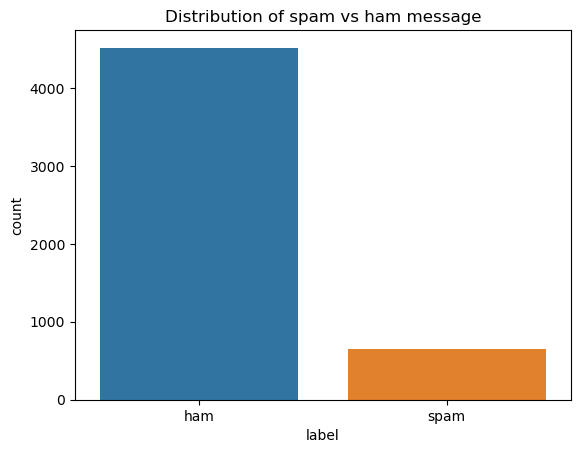

In [12]:
# Visualization: Distributing the spam
sns.countplot(x='label', data=clean_df)
plt.title('Distribution of spam vs ham message')
plt.show()

C:\Users\SAROJ\AppData\Local\Temp\ipykernel_12356\3561824594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['message_length'] = clean_df['message'].apply(len)
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


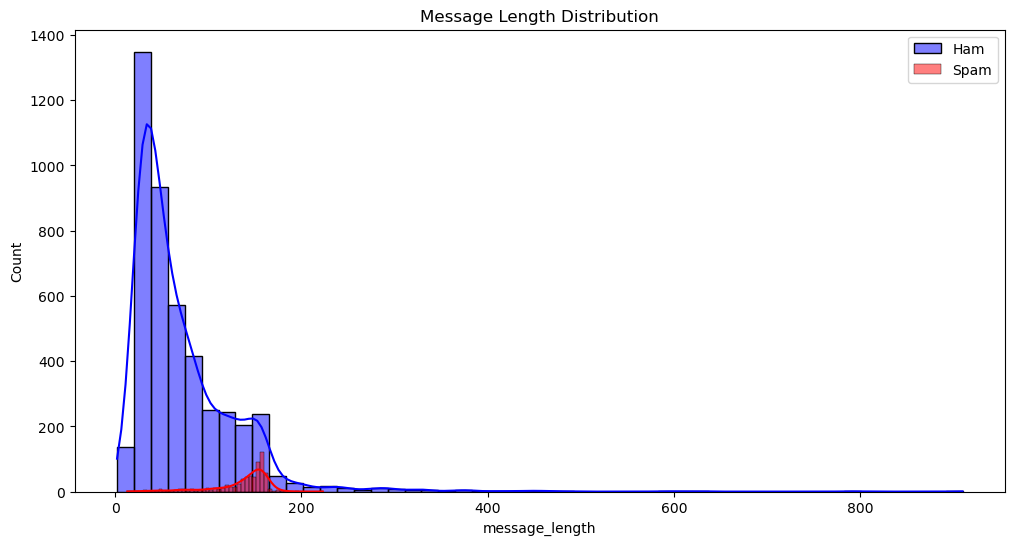

In [13]:
# Visualize the lenght of message
clean_df['message_length'] = clean_df['message'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(clean_df[clean_df['label'] == 'ham']['message_length'], label='Ham', color='blue', bins=50, kde=True)
sns.histplot(clean_df[clean_df['label'] == 'spam']['message_length'], label='Spam', color='red', bins=50, kde=True)
plt.title('Message Length Distribution')
plt.legend()
plt.show()

In [14]:
# Visualization: Word clouds for spam and ham messages
spam_words = ' '.join(clean_df[clean_df['label'] == 'spam']['message'])
ham_words = ' '.join(clean_df[clean_df['label'] == 'ham']['message'])

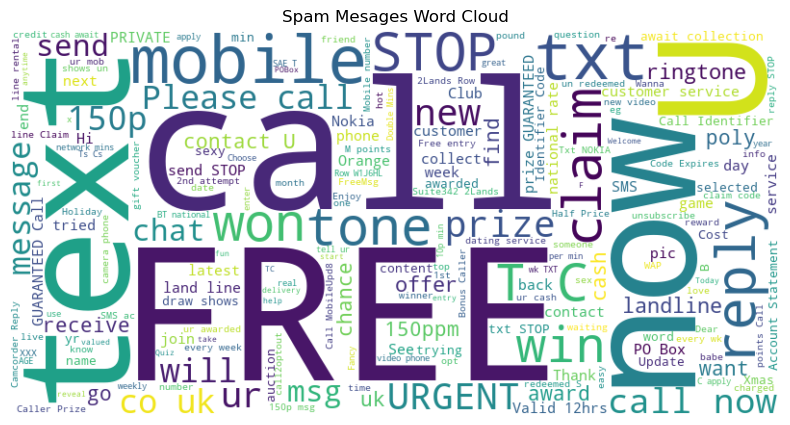

In [15]:
spam_wordCloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)
plt.figure(figsize=(10,5))
plt.imshow(spam_wordCloud, interpolation='bilinear')
plt.title('Spam Mesages Word Cloud')
plt.axis('off')
plt.show()

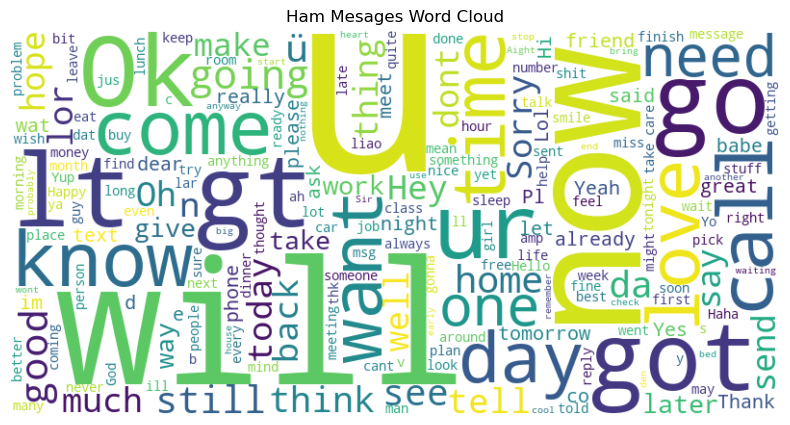

In [16]:
ham_wordCloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
plt.figure(figsize=(10,5))
plt.imshow(ham_wordCloud, interpolation='bilinear')
plt.title('Ham Mesages Word Cloud')
plt.axis('off')
plt.show()

In [17]:
# EDA: Tokenization and common word analysis
clean_df['tokens'] = clean_df['message'].apply(word_tokenize)
spam_tokens = [token for sublist in clean_df[clean_df['label'] == 'spam']['tokens'] for token in sublist]
ham_tokens = [token for sublist in clean_df[clean_df['label'] == 'ham']['tokens'] for token in sublist]

C:\Users\SAROJ\AppData\Local\Temp\ipykernel_12356\3132156619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['tokens'] = clean_df['message'].apply(word_tokenize)


In [18]:
spam_common_words = Counter(spam_tokens).most_common(20)
ham_common_words = Counter(ham_tokens).most_common(20)

In [19]:
spam_common_df = pd.DataFrame(spam_common_words, columns=['word', 'count'])
ham_common_df = pd.DataFrame(ham_common_words, columns=['word', 'count'])

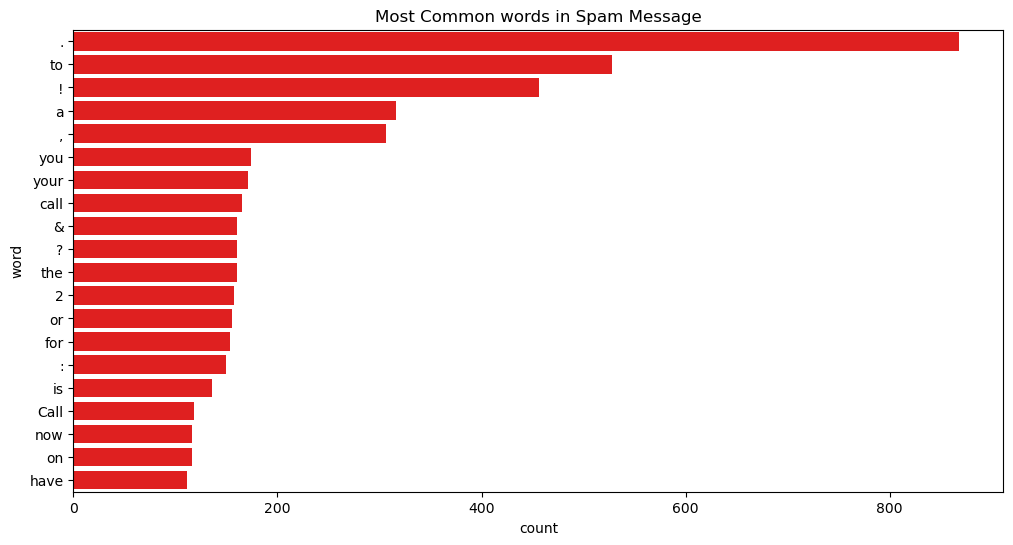

In [20]:
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data = spam_common_df, color='red')
plt.title('Most Common words in Spam Message')
plt.show()

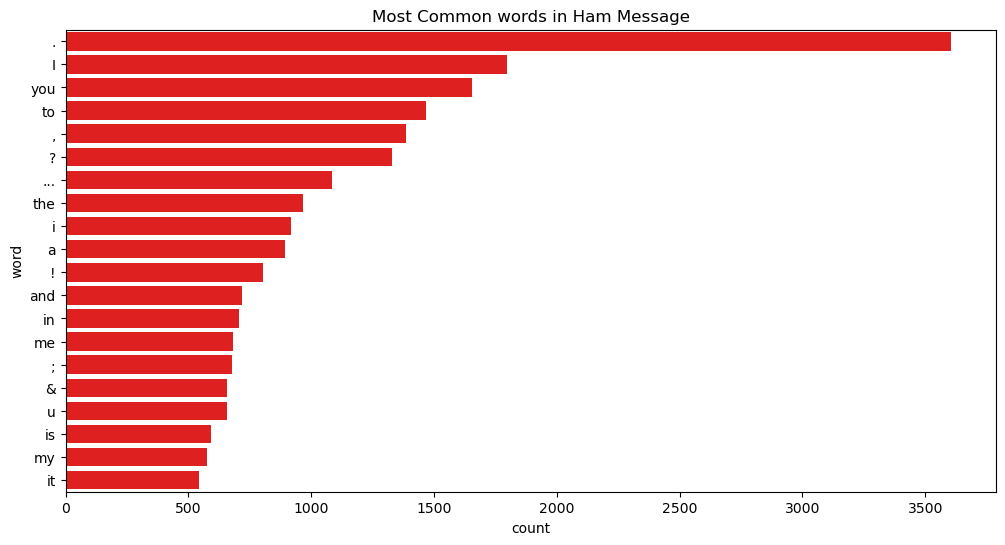

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data = ham_common_df, color='red')
plt.title('Most Common words in Ham Message')
plt.show()

In [22]:
# Data cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '. join(text.split())
    return text
clean_df['message'] = clean_df['message'].apply(clean_text)

C:\Users\SAROJ\AppData\Local\Temp\ipykernel_12356\3042362381.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['message'] = clean_df['message'].apply(clean_text)


In [23]:
# Data Preprocessing
X = clean_df['message']
y = clean_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135,), (1034,), (4135,), (1034,))

In [25]:
# Feature engineering: Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [26]:
# Model Selection and Training
# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [27]:
# Linear SVC
svc_model = LinearSVC(dual=False)
svc_model.fit(X_train_tfidf, y_train)

LinearSVC(dual=False)

In [28]:
# Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [29]:
# Model Evaluation
nb_predictions = nb_model.predict(X_test_tfidf)
svc_predictions = svc_model.predict(X_test_tfidf)
rf_predictions = rf_model.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score
# Accuracy computation
nb_accuracy = accuracy_score(y_test, nb_predictions)
svc_accuracy = accuracy_score(y_test, svc_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)

# Print the accuracy
print(f'Multinomial Naive Bayes Accuracy: {nb_accuracy*100:.2f}%')
print(f'Support Vector Classifier Accuracy: {svc_accuracy*100:.2f}%')
print(f'Random Forest Classifier Accuracy: {rf_accuracy*100:.2f}%')

Multinomial Naive Bayes Accuracy: 95.55%
Support Vector Classifier Accuracy: 98.26%
Random Forest Classifier Accuracy: 97.00%
